# Pryngles module

## Module base

Goals of the module:
- Future `base`
- Basic Classes and functions of the Class.
- It is based on existing infrastructure.

In [1]:
##HEADER
from pryngles import *
from pryngles import __version__
import rebound as rb
import unittest
import string
import random

import sys
IN_JUPYTER='ipykernel' in sys.modules

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK

----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK


## General classes

In this section of the package we introduce several useful classes for the module.

In [2]:
"""DEVELOPERS:

    _props is a class intended to treat the basic properties of an object 
    as an object and not as a dictionary.
    
    If you add another set of attributes just add the name of the attribute
    to the global variable _PROP_TYPES.
    
    Usage:
    
        
"""
_PROP_TYPES=["orbit","physics","optics"]
class _props():
    def __init__(self,**pars):
        self.__dict__.update(**pars)
    def __str__(self):
        return str(self.__dict__)

In [3]:
if IN_JUPYTER:
    def test_props(self):
        p=_props(m=1,a=2,b=3)
        self.assertEqual([p.m,p.a,p.b],[1,2,3],[True]*3)

    class Test(unittest.TestCase):pass
    Test.test_props=test_props
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.
----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


Each class is tested inmediately.  This will not appear when the module is converted.

### The body class

The Body class is one of the most important classes in the package. 

Before any major class we create the docstring of the class.  This eases the development.

In [4]:
Body_doc=\
"""A general body.
    
Initialization attributes:

    kind : string
        One of the kind of bodies defined in the package (see _BODY_KINDS)

    primary: Body
        Object in the center of the orbit of this body.

    orbit: _props
        Object with the orbital properties of the body (eg. orbit.m is the mass)
        see each specific Body definition for attributes.
        orbit must be compatible with rebound.

    physics: _props
        Object with the physical properties of the body (eg. physics.radius)
        see each specific Body definition for attributes.

    optics: _props
        Object with the optical properties of the body (eg. physics.lamb_albedo)
        see each specific Body definition for attributes.

Secondary attributes:

    hash: string
        Hash of the object, ie. a unique string identifying the object 
        (see hash Python function)

    parent: Body
        Body around this body is.  Attribute parent is the same as body.

    childs: list
        List with child bodies (bodies which have this body) as the center.

Public methods:

    update_body(props):
        Update a given property.
"""

In [5]:
"""DEVELOPERS:

    There are different kind of bodies in Pryngles.  The global list _BODY_KINDS is built
    by adding new kind of objects.
"""
_BODY_KINDS=[]

class Body(PrynglesCommon):
    
    def __init__(self,defaults,kind,primary,orbit,physics,optics):
        
        #Update default properties
        new_orbit=defaults.orbit.copy()
        new_physics=defaults.physics.copy()
        new_optics=defaults.optics.copy()
        
        new_orbit.update(**orbit)
        new_physics.update(**physics)
        new_optics.update(**optics)
        
        self.kind=kind
        self.primary=primary
        if self.primary is not None:
            if not isinstance(self.primary,Body):
                raise AssertionError(f"Primary is not a valid Object")            
        
        self.orbit=_props(**new_orbit)
        self.physics=_props(**new_physics)
        self.optics=_props(**new_optics)
        if 'hash' in self.orbit.__dict__:
            self.hash=self.orbit.hash
        else:
            self.hash=str(hash(self))
    
    def update_body(self,**props):
        """Update properties of the Body.
        
        Parametes:
            orbit: _props                
            physics: _props
            optics: _props
                Properties to update. The current object orbit is updated with new 
                values provided in this new object
                
        Example:
        
            B.update_body(orbit=dict(m=2))
                This only update the attribute m of orbit.
        """
        for prop in _PROP_TYPES:
            if prop in props and type(props[prop]) is dict:
                new_prop=self.__dict__[prop].__dict__
                new_prop.update(**props[prop])
                props[prop]=_props(**new_prop)
        
        self.__dict__.update(props)
        self._update_childs()
        self._update_parent()
    
    def _update_childs(self,child=None):
        if 'childs' not in self.__dict__:
            self.childs=[]
        if child is not None:
            self.childs+=[child]
            
    def _update_parent(self,parent=None):
        if 'parent' not in self.__dict__:
            self.parent=parent
        elif parent is not None:
            self.parent=parent
            
Body.__doc__=Body_doc

In [6]:
if IN_JUPYTER:
    def test_body(self):
        class defaults(object):
            orbit=dict()
            physics=dict()
            optics=dict()
        P=Body(defaults,"Test",None,dict(),dict(),dict())
        obj=Body(defaults,"Test",P,dict(),dict(),dict())
        obj._update_parent("parent")
        obj._update_childs("child1")
        obj._update_childs("child2")
        print(obj.childs)
        print(obj.hash)
        self.assertEqual([obj.parent],["parent"],True)
        self.assertEqual(obj.childs,["child1","child2"],True)
        self.assertRaises(AssertionError,
                          lambda:Body(defaults,"Test",1,dict(),dict(),dict())
                         )   

    class Test(unittest.TestCase):pass    
    Test.test_body=test_body
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

['child1', 'child2']
8773228156359



----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


## Specific objects

Here we define the classes for specific objects.

Default classes are classes that contains the default value of the main properties of the corresponding class.

In [7]:
class _StarDefaults(object):
    """
    These are the default attributes for bodies of the kind 'Star'.
    
    DEVELOPER:
        You may add new attributes as the model gets more complex.
        Please document properly each attribute.
        
    orbit:
    
        These attributes should be compatible with rebound.
    
        m: float [rebound mass units], default = 1
            Mass of the body.  If m = 0 the body does not produce gravitation.
            
    physics:
    
        radius: float [rebound length units], default = 1
            Radius of the body.
            
        prot: float [rebound time units], default = 1
            Period of rotation
            
    optics:
    
        limb_coeffs: list [adimensional], default = []
            List of limb darkening fit coefficients.
            
        nspangles: int, default = 1000
            Number of spangles on which the object will be discretized.
    """
    orbit=dict(m=1)
    
    physics=dict(radius=1,prot=1)

    optics=dict(limb_coeffs=[],
                nspangles=1000)

In [8]:
_BODY_KINDS+=["Star"]
class Star(Body):
    """Class star.
    
    See Body class documentation.
    
    Additional public attributes:
    
        physics.wrot: float
            Rotational angular velocity
    
    Override methods:
    
        update_body(**pars):
            This method compute additional attributes like (see above):
            
                physics.wrot
    """
    def __init__(self,
                 primary=None,
                 orbit=_StarDefaults.orbit,
                 physics=_StarDefaults.physics,
                 optics=_StarDefaults.optics
                ):
        
        
        #Instantiate object with basic properties
        Body.__init__(self,_StarDefaults,"Star",primary,orbit,physics,optics)

        #Check primary
        if self.primary is not None:
            if self.primary.kind=="Planet":
                raise ValueError(f"Planet cannot be the primary of a Star")
            self.primary._update_childs(self)
            self._update_parent(self.primary)
                
        #Update properties
        self.update_body(**self.__dict__)
        
    def update_body(self,**pars):
        Body.update_body(self,**pars)
        
        #Here place the commands to update this kind of body
        self.physics.wrot=2*np.pi/self.physics.prot

In [9]:
if IN_JUPYTER:
    def test_star(self):
        S=Star()
        print(S.physics)
        print(S.hash)
        
        #Check derived properties
        self.assertEqual(np.isclose([S.physics.wrot],
                                    [2*np.pi/_StarDefaults.physics["prot"]],
                                    rtol=1e-7),
                         [True]*1)
        
        S.update_body(physics=dict(m=2))
        print(S.physics)
        
        #Check exception: primary could not be different from None or Body
        self.assertRaises(AssertionError,lambda:Star(primary="Nada"))
        
    class Test(unittest.TestCase):pass    
    Test.test_star=test_star
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

{'radius': 1, 'prot': 1, 'wrot': 6.283185307179586}
8773228150989
{'radius': 1, 'prot': 1, 'wrot': 6.283185307179586, 'm': 2}



----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


In [10]:
class _PlanetDefaults(object):
    """
    These are the default attributes for bodies of the kind 'Planet'.
    
    DEVELOPER:
        You may add new attributes as the model gets more complex.
        Please document properly each attribute.
        
    orbit:
    
        These attributes should be compatible with rebound.
    
        m: float [rebound mass units], default = 1
            Mass of the body.  If m = 0 the body does not produce gravitation.
            
        a: float [rebound length units], default = 1.0
            Semi major axis of the orbit with respect to primary.
            
        e: float [adimentional], default = 0.0
            Eccentricity of the orbit with respect to primary.
            
    physics:
    
        radius: float [rebound length units], default = 1
            Radius of the body.
            
        prot: float [rebound time units], default = 1
            Period of rotation
            
    optics:
    
        nspangles: int, default = 1000
            Number of spangles on which the object will be discretized.
    """

    orbit=dict(m=1.0,a=1.0,e=0.0)
    
    physics=dict(radius=1.0,prot=1.0)
    
    optics=dict(nspangles=1000)

In [11]:
_BODY_KINDS+=["Planet"]

class Planet(Body):
    """Class Planet.
    
    See Body class documentation.
    
    Additional public attributes:
    
        physics.wrot: float
            Rotational angular velocity
    
    Override methods:
    
        update_body(**pars):
            This method compute additional attributes like (see above).
    """
    def __init__(self,
                 primary=None,
                 orbit=_PlanetDefaults.orbit,
                 physics=_PlanetDefaults.physics,
                 optics=_PlanetDefaults.optics
                ):
        
        
        #Instantiate object with basic properties
        Body.__init__(self,_PlanetDefaults,"Planet",primary,orbit,physics,optics)
        
        #Check primary
        if self.primary is None:
            raise ValueError(f"Primary not provided and it is mandatory for {self.kind}.")
        self.primary=primary
        self.primary._update_childs(self)
        self._update_parent(self.primary)
        
        #Update properties
        self.update_body(**self.__dict__)
        
    def update_body(self,**pars):
        Body.update_body(self,**pars)
        
        #Here place the commands to update this kind of body
        self.physics.wrot=2*np.pi/self.physics.prot

In [12]:
if IN_JUPYTER:
    def test_planet(self):
        S=Star()

        #Check exception: primary is mandatory for planets
        self.assertRaises(ValueError,lambda:Planet())

        P=Planet(primary=S)
        
        print(P.physics)
        print(P.hash)
        
        #Check derived properties
        self.assertEqual(np.isclose([P.physics.wrot],
                                    [2*np.pi/_PlanetDefaults.physics["prot"]],
                                    rtol=1e-7),
                         [True]*1)
        
        P.update_body(orbit=dict(a=5),physics=dict(rho=0.2))
        print(P.orbit,P.physics)
        
        #Check exception: primary could not be different from None or Body
        self.assertRaises(AssertionError,lambda:Planet(primary="Nada"))
        
    class Test(unittest.TestCase):pass    
    Test.test_planet=test_planet
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

{'radius': 1.0, 'prot': 1.0, 'wrot': 6.283185307179586}
8773228156260
{'m': 1.0, 'a': 5, 'e': 0.0} {'radius': 1.0, 'prot': 1.0, 'wrot': 6.283185307179586, 'rho': 0.2}



----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


In [13]:
class _RingDefaults(object):
    """
    These are the default attributes for bodies of the kind 'Ring'.
    
    DEVELOPER:
        You may add new attributes as the model gets more complex.
        Please document properly each attribute.
        
    orbit:
    
        (In current version, Ring body does not have orbit attributes)
        
    physics:
    
        fi: float [adimensional], default = 1
            Fraction of the radius of the primary object where ring stars.
            
        fe: float [adimensional], default = 1
            Fraction of the radius of the primary object where ring ends.
            
        i: float [radians], default = 0
            Inclination of the ring with respect to the equator of the primary
            object.
            
    optics:
    
        nspangles: int, default = 1000
            Number of spangles on which the object will be discretized.
    """
    orbit=dict()
    
    physics=dict(fi=1.0,fe=2.0,i=0.0)
    
    optics=dict(nspangles=1000)

In [14]:
_BODY_KINDS+=["Ring"]

class Ring(Body):
    """Class Planet.
    
    See Body class documentation.
    
    Additional public attributes:
    
        physics.ri: float [rebound length unit]
            Radius of the inner border of the ring

        physics.re: float [rebound length unit]
            Radius of the outer border of the ring
    
    Override methods:
    
        update_body(**pars):
            This method compute additional attributes like (see above).
    """
    def __init__(self,
                 primary=None,
                 orbit=_RingDefaults.orbit,
                 physics=_RingDefaults.physics,
                 optics=_RingDefaults.optics
                ):
        
        
        #Instantiate object with basic properties
        Body.__init__(self,_RingDefaults,"Ring",primary,orbit,physics,optics)
        
        #Check primary
        if self.primary is None:
            raise ValueError(f"Primary not provided and mandatory for {self.kind}.")
        self.primary=primary
        self.primary._update_childs(self)
        self._update_parent(self.primary)
        
        #Update properties
        self.update_body(**self.__dict__)
        
    def update_body(self,**pars):
        Body.update_body(self,**pars)
        
        #Here place the commands to update this kind of body
        self.physics.ri=self.physics.fi*self.primary.physics.radius
        self.physics.re=self.physics.fe*self.primary.physics.radius

In [15]:
if IN_JUPYTER:
    def test_planet(self):
        S=Star(physics=dict(radius=3.0))

        #Check exception: primary is mandatory for planets
        self.assertRaises(ValueError,lambda:Ring())

        R=Ring(primary=S)
        
        print(R.physics)
        print(R.hash)
        
        #Check derived properties
        """
        self.assertEqual(np.isclose([P.physics.wrot],
                                    [2*np.pi/_PlanetDefaults.physics["prot"]],
                                    rtol=1e-7),
                         [True]*1)
        """
        
        R.update_body(physics=dict(fe=3))
        print(R.physics)
        
        #Check exception: primary could not be different from None or Body
        self.assertRaises(AssertionError,lambda:Planet(primary="Nada"))
        
    class Test(unittest.TestCase):pass    
    Test.test_planet=test_planet
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

{'fi': 1.0, 'fe': 2.0, 'i': 0.0, 'ri': 3.0, 're': 6.0}
8773228155143
{'fi': 1.0, 'fe': 3, 'i': 0.0, 'ri': 3.0, 're': 9.0}



----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


In [16]:
class _ObserverDefaults(object):
    """
    These are the default attributes for bodies of the kind 'Observer'.
    
    DEVELOPER:
        You may add new attributes as the model gets more complex.
        Please document properly each attribute.
        
    orbit:
    
        (In current version, Observer body does not have orbit attributes)
        
    physics:
    
        (In current version, Observer body does not have physics attributes)
            
    optics:
    
        distance: float [rebound length units], default = 1
            Distance at which the observer is located
            
        beta: float [radians], default = 0
            Ecliptic latitude.  Elevation with respect to the plane of the planetary 
            system from which the observer is looking at the system.  beta = 0 is for 
            edge-on observations, beta = 90 degrees is for face-on observations.
            
        lamb: float [radians], default = 0
            Ecliptic longitude. Angle with respect to the zero meridian of the planetary 
            system.
            
            NOTE: zero meridian is defined differently depending on the observed object.
                  in the case of a ring, zero meridian is the direction of vernal equinox.
    
        nspangles: int, default = 1000
            Number of spangles on which the object will be discretized.
    """
    orbit=dict()
    
    physics=dict()
    
    optics=dict(distance=1,beta=0,lamb=0)

In [17]:
_BODY_KINDS+=["Observer"]

class Observer(Body):
    """Class Observer.
    
    See Body class documentation.
    
    Additional public attributes:
    
        physics.inclination: float [radians]
            Angle of inclination of the normal to the ecliptic in the system with 
            respect to line-of-sight.  When inclination = 0 system is observed face-on.
            When inclination = 90 degress system is observed edge-on.

    Override methods:
    
        update_body(**pars):
            This method compute additional attributes like (see above).
    """
    def __init__(self,
                 primary=None,
                 orbit=_ObserverDefaults.orbit,
                 physics=_ObserverDefaults.physics,
                 optics=_ObserverDefaults.optics
                ):
        
        
        #Instantiate object with basic properties
        Body.__init__(self,_ObserverDefaults,"Observer",primary,orbit,physics,optics)
        
        #Check if observer is attached to any object
        self.primary=primary
        if self.primary is not None:
            self.primary._update_childs(self)
            self._update_parent(self.primary)
        
        #Update properties
        self.update_body(**self.__dict__)
        
    def update_body(self,**pars):
        Body.update_body(self,**pars)
        
        #Here place the commands to update this kind of body
        self.optics.inclination = 90*DEG - self.optics.beta

In [18]:
if IN_JUPYTER:
    def test_observer(self):
        O=Observer()
        print(O.optics)
        
        #Check derived properties
        """
        self.assertEqual(np.isclose([P.physics.wrot],
                                    [2*np.pi/_PlanetDefaults.physics["prot"]],
                                    rtol=1e-7),
                         [True]*1)
        """
        
        O.update_body(optics=dict(beta=90*DEG))
        print(O.optics)
        
        #Check exception: primary could not be different from None or Body
        self.assertRaises(AssertionError,lambda:Observer(primary="Nada"))
        
    class Test(unittest.TestCase):pass    
    Test.test_observer=test_observer
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

{'distance': 1, 'beta': 0, 'lamb': 0, 'inclination': 1.5707963267948966}
{'distance': 1, 'beta': 1.5707963267948966, 'lamb': 0, 'inclination': 0.0}



----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


## The system class

This is the most important class in the whole package.  This class allows to create the planetary system and manipulate it.

In [19]:
System_doc=\
f"""
Creates a planetary system.

Examples:

    sys=System()
    sys=System(units=['km','msun','s'])
    S=Star()
    P=Planet(primary=S)
    sys=System(stars=S,planets=P)

Initialization attributes:

    units: list of strings, default = ['au','msun','yr']:
        Units used in calculations following the conventions and signs of rebound.
        The order SHOULD always be: length, mass, time.
        
    stars: list or single Body.  default = None: 
        Star(s) in the system.
        
    planets: list or single Body.  default = None: 
        Planet(s) in the system.
        
    rings: list or single Body.  default = None: 
        Ring(s) in the system.

    observers: list or single Body.  default = None: 
        Observer(s) in the system.
    
    rebound: bool, default = True:
        Set True if you want to simulte the orbit of objects (for instance if you want to calculate
        TTVs or TDVs) or False if you want to calculate orbits using Keplerian dynamics (no TTVs or TDVs).
        
        NOTE: Current version ({__version__}) does not implement yet rebound simulations

Secondary attributes:

    hashes: list
        List of hashes of bodies in the system.
        
    stars, planets, rings, observers: list
        List of the corresponding kind of object in the system.
        
    nstars, nplanets, nrings, nobservers: int
        Number of each kind of body in the system.
    
    nbodies: int
        Number of bodies in the system.
        
    ul, um, ut: float [SI units]
        Value of the conversion factors for each unit.
        
    G: float [ul^3/ut^2/um]
        Value of the gravitational constant.

Usefule private attributes:

    _sim: rebound Simulation.
        Rebound simulation object.
""";

In [20]:
class System(PrynglesCommon):
    
    def __init__(self,
                 units=['au','msun','yr'],
                 stars=None,planets=None,
                 rings=None,observers=None,
                 rebound=False
                ):
        
        #Initialize rebound
        self.units=units
        self._update_units()
        
        #Behavior
        self.rebound=rebound
        self.rebound=False # Rebound not implemented yet
        self._update_rebound()
        
        #Initialize list of components
        self.hashes=dict()
        for kind in _BODY_KINDS:
            lkind=kind.lower()
            exec(f"self.{lkind}s=[]")
            exec(f"self._update_objects('{lkind}s','{kind}',{lkind}s)")

        #Update system
        self._update_system()
    
    def _update_objects(self,attr,kind,comps):
        """Update the list of objects
        """

        if comps is not None:
            #Check if comps is a a list
            try:
                comps[0]
            except:
                comps=[comps]
            
            for comp in comps:
                #Check if primary bodies are already in lists
                if (comp.primary is not None) and (comp.primary.hash not in self.hashes):
                    raise AssertionError(f"Primary of {kind} body is not yet in the system.")
                else:
                    exec(f"self.{attr}+=[comp]")
                    if comp.kind!=kind:
                        raise AssertionError(f"You are attempting to add {kind} with a {comp.kind}")
                    self.hashes[comp.hash]=comp

    def _update_system(self):
        """Update the global properties of the system.
        """
        for kind in _BODY_KINDS:
            exec(f"self.{kind}s=0")
        
        pdict=dict()
        for obj in _BODY_KINDS:
            lobj=obj.lower()
            exec(f"{obj}=len(self.{lobj}s)",locals(),pdict)
            self.__dict__[f"n{lobj}s"]=pdict[obj]
        self.nbodies=self.nstars+self.nplanets+self.nrings
        
    def _update_units(self):
        """Update units of the system
        """
        self._ul,self._um,self._ut=self.units
        self.ul=rb.units.convert_length(1,self._ul,"m")
        self.um=rb.units.convert_mass(1,self._um,"kg")
        self.ut=np.sqrt(self.ul**3/(self.um*GSI))

    def _update_rebound(self):
        """Crteate and update rebound simulation object
        """
        #Units initialization
        self._sim=rb.Simulation()
        self._sim.units=self.units
        self.G=self._sim.G

System.__doc__=System_doc

In [21]:
if IN_JUPYTER:
    def test_system_init(self):
        
        sys=System()
        print(sys.nbodies)
        print(sys.G)
        print(sys.ul,sys.um,sys.ut)
        
        sys=System(units=['m','kg','s'])
        print(sys.nbodies)
        print(sys.G)
        print(sys.ul,sys.um,sys.ut)
        
        S=Star()
        sys=System(stars=S)
        print(sys.stars)
        print(sys.hashes)
        print(sys.nbodies,sys.nstars,sys.nplanets,sys.nrings,sys.nobservers)
        
        S2=Star()
        P=Planet(primary=S2)
        #Check that when planet does not use a star of the system an exception is raised
        self.assertRaises(AssertionError,lambda:System(stars=S,planets=P))
        
        P=Planet(primary=S)
        sys=System(stars=S,planets=P)
        print(sys.hashes)
        print(sys.nbodies,sys.nstars,sys.nplanets,sys.nrings,sys.nobservers)
        
        R=Planet(primary=P)
        #Check that planet cannot be initialized as a planet
        self.assertRaises(AssertionError,lambda:System(stars=S,planets=P,rings=R))

        R=Ring(primary=P)
        sys=System(stars=S,planets=P,rings=R)
        print(sys.hashes)
        print(sys.nbodies,sys.nstars,sys.nplanets,sys.nrings,sys.nobservers)
        
        
        P1=Planet(primary=S)
        P2=Planet(primary=S)
        P3=Planet(primary=S)
        sys=System(stars=S,planets=[P1,P2,P3])
        print(sys.hashes)
        print(sys.nbodies,sys.nstars,sys.nplanets,sys.nrings,sys.nobservers)
        
        """
        self.assertEqual(np.isclose([P.physics.wrot],
                                    [2*np.pi/_PlanetDefaults.physics["prot"]],
                                    rtol=1e-7),
                         [True]*1)
        #Check exception: primary could not be different from None or Body
        self.assertRaises(AssertionError,lambda:Observer(primary="Nada"))
        """
        
    class Test(unittest.TestCase):pass    
    Test.test_system_init=test_system_init
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

0
39.476926421373
149597870700.0 1.9884754159665356e+30 5022642.890913031
0
6.67408e-11
1.0 1.0 122406.4480636431
{'8773228161729': <__main__.Star object at 0x7faad25eac10>}
1 1 0 0 0
{'8773228161729': <__main__.Star object at 0x7faad25eac10>, '8773227218770': <__main__.Planet object at 0x7faad1787520>}
2 1 1 0 0
{'8773228161729': <__main__.Star object at 0x7faad25eac10>, '8773227218770': <__main__.Planet object at 0x7faad1787520>, '8773259714762': <__main__.Ring object at 0x7faaf0760ca0>}
3 1 1 1 0
{'8773228161729': <__main__.Star object at 0x7faad25eac10>, '8773228161600': <__main__.Planet object at 0x7faad25ea400>, '8773228161684': <__main__.Planet object at 0x7faad25ea940>, '8773228161762': <__main__.Planet object at 0x7faad25eae20>}
4 1 3 0 0



----------------------------------------------------------------------
Ran 1 test in 0.006s

OK


In [22]:
def add(self,kind=None,primary=None,orbit=None,physics=None,optics=None):
    """Add an object to the system
    
    Examples:
    
        sys=System()
        S=sys.add(kind="Star",orbit=dict(m=2))
    
    Parameters:
    
        kind: string
            Kind of object: Star, Planet, Ring, Observer.
    
        primary: Body
            Primary object.
    
        orbit: dictionary
            Set of orbital properties (see corresponding body documentation).
            
        physics: dictionary
            Set of physical properties (see corresponding body documentation).
        
        optics: dictionary
            Set of optical properties (see corresponding body documentation).
            
    Returns:
        
        Body
            Body added to the system.
    """
    if kind is None:
        raise AssertionError("You must provide a valid object kind (Star, Planet, Ring, Observer).")

    if kind not in _BODY_KINDS:
        raise ValueError(f"Object kind '{kind}' is not recognized.")

    #p.e. kind = 'Star', lkind = 'star'
    kind=kind.capitalize()
    lkind=kind.lower()

    """
    #This code generalize the procedure:
    if orbit is None:
        orbit = _StarDefaults.orbit.copy()
    if physics is None:
        physics = _StarDefaults.physics.copy()
    if optics is None:
        optics = _StarDefaults.optics.copy()
    """
    pdict=dict()
    plist=[]
    for prop in _PROP_TYPES:
        exec(f"{prop}={prop}",locals(),pdict)
        if pdict[prop] is None:
            exec(f"{prop}=_{kind}Defaults.{prop}.copy()",globals(),pdict)
        plist+=[pdict[prop]]

    """
    #This code generalize the procedure
    S=Star(primary=primary,orbit=orbit,physics=physics,optics=optics)
    self._list2Objects("stars","Star",S)            
    """
    obj=eval(f"{kind}(primary=primary,orbit=plist[0],physics=plist[1],optics=plist[2])")
    self._update_objects(lkind+"s",kind,obj)
    self._update_system()
    return obj
    
System.add=add

In [23]:
if IN_JUPYTER:
    def test_system_add(self):
        sys=System()
        S=sys.add(kind="Star",orbit=dict(m=2))
        print(sys.hashes)
        print(sys.nbodies,sys.nstars,sys.nplanets,sys.nrings,sys.nobservers)
        print(sys.stars[0].orbit)
        print(S.orbit)
        
        S.update_body(orbit=dict(m=3))
        print(sys.stars[0].orbit)
        
        """
        self.assertEqual(np.isclose([P.physics.wrot],
                                    [2*np.pi/_PlanetDefaults.physics["prot"]],
                                    rtol=1e-7),
                         [True]*1)
        #Check exception: primary could not be different from None or Body
        self.assertRaises(AssertionError,lambda:Observer(primary="Nada"))
        """
        
    class Test(unittest.TestCase):pass    
    Test.test_system_add=test_system_add
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

{'8773259714832': <__main__.Star object at 0x7faaf0761100>}
1 1 0 0 0
{'m': 2}
{'m': 2}
{'m': 3}



----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


In [24]:
def remove(self,body_hash):
    """Remove a body from a system.

    Example:
        sys=System()
        S=sys.add(kind="Star",orbit=dict(m=2))
        sys.remove(body_hash=S.hash)
        
    Parameters:
        body_hash: string
            Hash of the body to remove
        
    Remove eliminate body and all the childs and the childs of the childs.
    """
    if body_hash in self.hashes:
        obj=self.hashes[body_hash]
        lkind=obj.kind.lower()

        #Remove child objects
        for child in obj.childs:
            if child.hash in self.hashes:
                self.remove(child.hash)

        #Remove object
        exec(f"self.{lkind}s.remove(obj)")

        #Remove hash from list
        self.hashes.pop(body_hash)

        #Update system
        self._update_system()
    else:
        raise ValueError("No object with hash 'body_hash' in the system")
System.remove=remove

In [25]:
if IN_JUPYTER:
    def test_system_remove(self):
        sys=System()
        S=sys.add(kind="Star",orbit=dict(m=2))
        print(sys.hashes)
        print(sys.nbodies,sys.nstars,sys.nplanets,sys.nrings,sys.nobservers)

        sys.remove(body_hash=S.hash)
        print(sys.hashes)
        print(sys.nbodies,sys.nstars,sys.nplanets,sys.nrings,sys.nobservers)
        
        sys=System()
        S=sys.add(kind="Star")
        P=sys.add(kind="Planet",primary=S)
        R=sys.add(kind="Ring",primary=P)
        print(sys.hashes)
        print(sys.nbodies,sys.nstars,sys.nplanets,sys.nrings,sys.nobservers)

        sys.remove(body_hash=S.hash)
        print(sys.hashes)
        print(sys.nbodies,sys.nstars,sys.nplanets,sys.nrings,sys.nobservers)

        sys=System()
        S=sys.add(kind="Star")
        P=sys.add(kind="Planet",primary=S)
        R=sys.add(kind="Ring",primary=P)
        print(sys.hashes)
        print(sys.nbodies,sys.nstars,sys.nplanets,sys.nrings,sys.nobservers)

        sys.remove(body_hash=P.hash)
        print(sys.hashes)
        print(sys.nbodies,sys.nstars,sys.nplanets,sys.nrings,sys.nobservers)
        
        sys=System()
        S=sys.add(kind="Star")
        P=sys.add(kind="Planet",primary=S)
        R=sys.add(kind="Ring",primary=P)
        print(sys.hashes)
        print(sys.nbodies,sys.nstars,sys.nplanets,sys.nrings,sys.nobservers)

        sys.remove(body_hash=R.hash)
        print(sys.hashes)
        print(sys.nbodies,sys.nstars,sys.nplanets,sys.nrings,sys.nobservers)
        
        """
        self.assertEqual(np.isclose([P.physics.wrot],
                                    [2*np.pi/_PlanetDefaults.physics["prot"]],
                                    rtol=1e-7),
                         [True]*1)
        #Check exception: primary could not be different from None or Body
        self.assertRaises(AssertionError,lambda:Observer(primary="Nada"))
        """
        
    class Test(unittest.TestCase):pass    
    Test.test_system_remove=test_system_remove
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

{'8773227221252': <__main__.Star object at 0x7faad1791040>}
1 1 0 0 0
{}
0 0 0 0 0
{'8773227227474': <__main__.Star object at 0x7faad17a9520>, '8773227221252': <__main__.Planet object at 0x7faad1791040>, '8773227227633': <__main__.Ring object at 0x7faad17a9f10>}
3 1 1 1 0
{}
0 0 0 0 0
{'8773259714666': <__main__.Star object at 0x7faaf07606a0>, '8773259714642': <__main__.Planet object at 0x7faaf0760520>, '8773259714720': <__main__.Ring object at 0x7faaf0760a00>}
3 1 1 1 0
{'8773259714666': <__main__.Star object at 0x7faaf07606a0>}
1 1 0 0 0
{'8773259714732': <__main__.Star object at 0x7faaf0760ac0>, '8773228161768': <__main__.Planet object at 0x7faad25eae80>, '8773228161666': <__main__.Ring object at 0x7faad25ea820>}
3 1 1 1 0
{'8773259714732': <__main__.Star object at 0x7faaf0760ac0>, '8773228161768': <__main__.Planet object at 0x7faad25eae80>}
2 1 1 0 0



----------------------------------------------------------------------
Ran 1 test in 0.006s

OK


In [26]:
def ensamble_system(self):
    #Ensamble system
    #--CONSISTENCY--
    if self.nstars==1 and self.nplanets==1 and self.nrings==1:
        self._ringedplanet=dict(
            #Behavior
            behavior=dict(shadows=True),
            
            #Units
            CU=CanonicalUnits(UL=self.ul,UM=self.um),
            
            #Basic
            Rstar=self.stars[0].physics.radius,
            Rplanet=self.planets[0].physics.radius,
            
            Rint=self.rings[0].physics.fi,
            Rext=self.rings[0].physics.fe,
            i=self.rings[0].physics.i,
            
            a=self.planets[0].orbit.a,e=self.planets[0].orbit.e,
            
            #Orbit 
            Mstar=1,x=0,lambq=0,t0=0,kepler=False,
            
            #Observer
            eobs_ecl=np.array([self.observers[0].optics.lamb,
                               self.observers[0].optics.beta]),
            
            #Sampling
            Np=self.planets[0].optics.nspangles,
            Nr=self.rings[0].optics.nspangles,
            
            Nb=0,Ns=30,
            
            #Physical properties
            physics=dict(
                #Albedos
                AS=1,AL=1,
                #Ring geometrical opacity
                taug=1.0, #Geometrical opacity
                diffeff=1.0, #Diffraction efficiency
                #Law of diffuse reflection on ring surface
                reflection_rings_law=lambda x,y:x,
                #Observations wavelength
                wavelength=550e-9,
                #Ring particle propeties (see French & Nicholson, 2000)
                particles=dict(q=3,s0=100e-6,smin=1e-2,smax=1e2,Qsc=1,Qext=2),
                #Stellar limb darkening
                limb_cs=[0.6550],
            )
        )
        self.RP=RingedPlanet(**self._ringedplanet)
        return self.RP
    else:
        raise AssertionError(f"You must have at least one star ({self.nstars}), a planet ({self.nplanets}) and a ring ({self.nrings})")

System.ensamble_system=ensamble_system

0.004649131016042781 0.0003892513368983957 1.5 2.5 0.2 0.0
0.5235987755982988 1.5707963267948966
2.1245118303881245


<IPython.core.display.Javascript object>


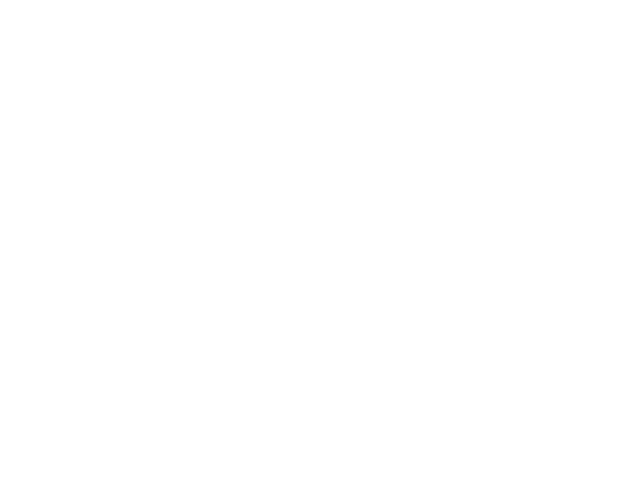

2.1245118303881245


<IPython.core.display.Javascript object>


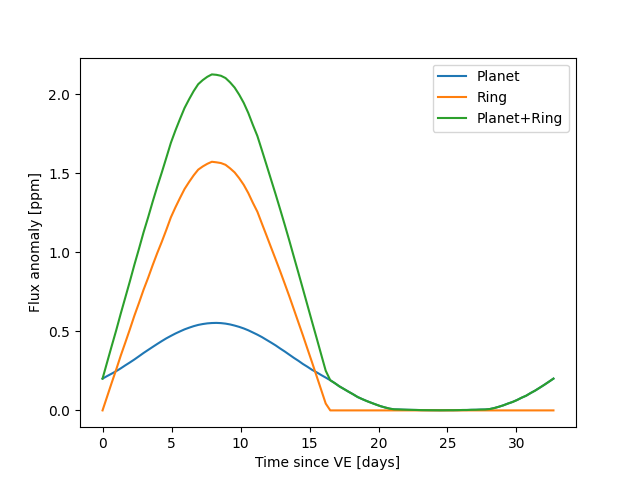

.
----------------------------------------------------------------------
Ran 1 test in 0.832s

OK


In [34]:
if IN_JUPYTER:
    def test_system_ensamble(self):

        sys=System()
        S=sys.add(kind="Star",
                  physics=dict(radius=Const.Rsun/Const.au))
        P=sys.add(kind="Planet",primary=S,
                  orbit=dict(a=0.2,e=0.0),
                  physics=dict(radius=Const.Rsat/Const.au)
                 )
        R=sys.add(kind="Ring",primary=P,
                  physics=dict(fi=1.5,fe=2.5,i=30*DEG)
                 )
        O=sys.add(kind="Observer",
                  optics=dict(beta=30*DEG,lamb=90*DEG)
                 )

        print(S.physics.radius,P.physics.radius,R.physics.fi,R.physics.fe,P.orbit.a,P.orbit.e)
        print(O.optics.beta,O.optics.lamb)
        
        P=sys.ensamble_system()
        fig1,fig2,fig3=P.plotRingedPlanet(showfig=0)
        
        P.changeObserver([90*DEG,30*DEG])
        lamb_initial=+0.0*DEG
        lamb_final=+360*DEG
        lambs=np.linspace(lamb_initial,lamb_final,100)
        Rps=[]
        Rrs=[]
        ts=[]
        for lamb in lambs:
            P.changeStellarPosition(lamb)
            ts+=[P.t*P.CU.UT]
            P.updateOpticalFactors()
            P.updateDiffuseReflection()
            Rps+=[P.Rip.sum()]
            Rrs+=[P.Rir.sum()]

        ts=np.array(ts)
        Rps=np.array(Rps)
        Rrs=np.array(Rrs)

        #Middle transit
        ts=(ts-ts[0])/Const.days

        print(max(1e6*(Rps+Rrs)))
        
        #Plot
        #"""
        fig=plt.figure()
        ax=fig.gca()    
        ax.plot(ts,1e6*Rps,label="Planet")
        ax.plot(ts,1e6*Rrs,label="Ring")
        ax.plot(ts,1e6*(Rps+Rrs),label="Planet+Ring")

        ax.set_xlabel("Time since VE [days]")
        ax.set_ylabel("Flux anomaly [ppm]")

        ax.legend();
        #"""
        
        #"""
        #LEGACY
        attributes=dict(
            #Behavior
            behavior=dict(shadows=True),
            #Units
            CU=CanonicalUnits(UL=P.CU.UL,UM=P.CU.UM),
            #Basic
            Rstar=Const.Rsun/Const.au,Rplanet=Const.Rsat/Const.au,
            Rint=1.5,Rext=2.5,i=30*DEG,a=0.2,e=0.0,
            #Orbit 
            Mstar=1,x=0,lambq=0,t0=0,kepler=False,
            #Observer
            eobs_ecl=np.array([90.0*DEG,30.0*DEG]),
            #Sampling
            Np=1000,Nr=1000,Nb=0,Ns=30,
            #Physical properties
            physics=dict(
                #Albedos
                AS=1,AL=1,
                #Ring geometrical opacity
                taug=1.0, #Geometrical opacity
                diffeff=1.0, #Diffraction efficiency
                #Law of diffuse reflection on ring surface
                reflection_rings_law=lambda x,y:x,
                #Observations wavelength
                wavelength=550e-9,
                #Ring particle propeties (see French & Nicholson, 2000)
                particles=dict(q=3,s0=100e-6,smin=1e-2,smax=1e2,Qsc=1,Qext=2),
                #Stellar limb darkening
                limb_cs=[0.6550],
            )
        )
        P=RingedPlanet(**attributes)
        fig1,fig2,fig3=P.plotRingedPlanet(showfig=0)

        P.changeObserver([90*DEG,30*DEG])
        lamb_initial=+0.0*DEG
        lamb_final=+360*DEG
        lambs=np.linspace(lamb_initial,lamb_final,100)
        Rps=[]
        Rrs=[]
        ts=[]
        for lamb in lambs:
            P.changeStellarPosition(lamb)
            ts+=[P.t*P.CU.UT]
            P.updateOpticalFactors()
            P.updateDiffuseReflection()
            Rps+=[P.Rip.sum()]
            Rrs+=[P.Rir.sum()]

        ts=np.array(ts)
        Rps=np.array(Rps)
        Rrs=np.array(Rrs)


        print(max(1e6*(Rps+Rrs)))

        #Middle transit
        ts=(ts-ts[0])/Const.days

        #Plot
        fig=plt.figure()
        ax=fig.gca()    
        ax.plot(ts,1e6*Rps,label="Planet")
        ax.plot(ts,1e6*Rrs,label="Ring")
        ax.plot(ts,1e6*(Rps+Rrs),label="Planet+Ring")

        ax.set_xlabel("Time since VE [days]")
        ax.set_ylabel("Flux anomaly [ppm]")

        ax.legend();
        #""";
        
        """
        self.assertEqual(np.isclose([P.physics.wrot],
                                    [2*np.pi/_PlanetDefaults.physics["prot"]],
                                    rtol=1e-7),
                         [True]*1)
        #Check exception: primary could not be different from None or Body
        self.assertRaises(AssertionError,lambda:Observer(primary="Nada"))
        """
        
    class Test(unittest.TestCase):pass    
    Test.test_system_ensamble=test_system_ensamble
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

--Test--

0.004649131016042781 0.0003892513368983957 1.5 2.5 0.2 0.0
0.5235987755982988 1.5707963267948966
2.1245118303881245


<IPython.core.display.Javascript object>


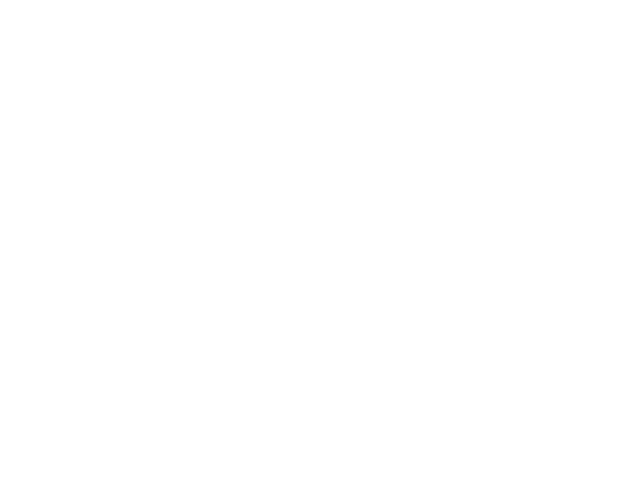

2.1245118303881245


<IPython.core.display.Javascript object>


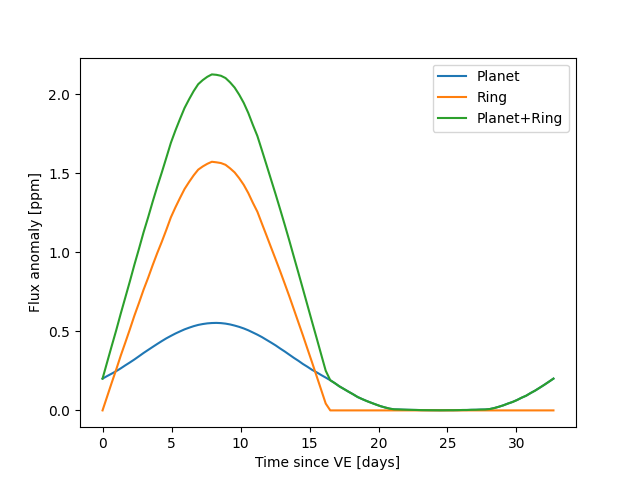

.
----------------------------------------------------------------------
Ran 1 test in 0.818s

OK


In [35]:
if __name__=="__main__":
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

--End--

## Debugging

# Convert

In [31]:
%%javascript
IPython.notebook.kernel.execute('FILE=\"' + IPython.notebook.notebook_name + '\"')

<IPython.core.display.Javascript object>

In [32]:
!make -C .. DEVFILES=dev/{FILE} convert

Converting iPython Notebooks dev/pryngles-_base.ipynb...
Analysing file pryngles-_base.ipynb:
	Directory: src//pryngles
	Filename: _base
	Target object: src//pryngles/_base.py
	Converting from ipynb dev/pryngles-_base.ipynb to python src//pryngles/_base.py...
	Processing magic commands...
	Triming end...
	Triming test...
	Using as template src/.temp
	Creating test file src//pryngles/tests/test-_base.py...
Completed.
